In [2]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2
from sklearn.model_selection import train_test_split 

In [25]:
def Data_List(path):
    filename = os.listdir(path)
    datalist = pd.DataFrame(data=[], columns=['label','img'])
    label = []
    img = []

    for file in tqdm(filename):
        label.append(file.split('.')[0])
        img.append(file)
    
    datalist['label'] = label
    datalist['img'] = img
    return datalist
    
def Data_Chart(datalist, Class1 , Class2 ):
    catnum = 0
    dognum = 0

    for i in datalist['label']:
        if i == Class1:
            catnum += 1
        if i == Class2:
            dognum += 1
    #Normal 데이터 갯수 Bad와 비슷하게 맞추기.
    plt.bar([1,2],[catnum, dognum],tick_label=[Class1,Class2]) 
    plt.legend()   
    
    
def Preprocessing(path, Class1) :
    X = []
    Y = []
    class_label = []
    class_num = 2
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == Class1: 
            X.append(img) 
            Y.append(0) 
        else : 
            X.append(img) 
            Y.append(1)

    tmpx = np.array(X) 

    Y = np.array([[i] for i in Y]) 
    enc = OneHotEncoder(categories='auto') 
    enc.fit(Y) 
    tmpy = enc.transform(Y).toarray() 

    del X 
    del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return tmpx , tmpy , class_label , class_num

def Split_Augmentation(tmpx, tmpy):
    X_train, X_val, Y_train, Y_val = train_test_split(tmpx,tmpy, test_size = 0.2,random_state = 1) 
    
    batch_size = 4

    train_datagen = ImageDataGenerator( 
        rescale=1. / 255, rotation_range=360,
        horizontal_flip=True, vertical_flip=True) 

    val_datagen = ImageDataGenerator( 
        rescale=1. / 255, rotation_range=360,
        horizontal_flip=True, vertical_flip=True) 

    train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 
    validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)
    return X_train, X_val, Y_train, Y_val, train_generator, validation_generator

def Integrated(path, Class1, Class2):
    datalist = Data_List(path)
    Data_Chart(datalist, Class1, Class2)
    tmpx , tmpy , class_label , class_num = Preprocessing(path, Class1)
    print(tmpx.shape, tmpy.shape)
    X_train, X_val, Y_train, Y_val, train_generator, validation_generator = Split_Augmentation(tmpx, tmpy)
    return X_train, X_val, Y_train, Y_val, train_generator, validation_generator

100%|████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<?, ?it/s]
No handles with labels found to put in legend.
100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 612.92it/s]

(129, 160, 160, 3) (129, 2)


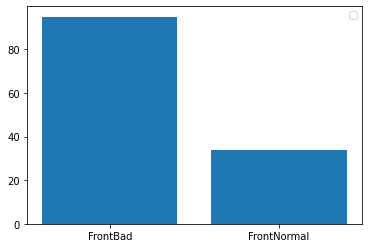

In [26]:
X_train, X_val, Y_train, Y_val, train_generator, validation_generator = Integrated('C:/Users/sdf80/Desktop/fruit_dataset2/Bad_Normal/Front/Mix/', 'FrontBad', 'FrontNormal')

nb_train_samples = len(X_train) 
nb_validation_samples = len(X_val) 

In [27]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop

pre_trained_model = InceptionV3(input_shape=(160, 160, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [30]:
batch_size = 4

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
25/25 [==============================] - 34s 1s/step - loss: 16.3931 - accuracy: 0.7475 - val_loss: 0.7316 - val_accuracy: 0.5000
Epoch 2/30
25/25 [==============================] - 36s 1s/step - loss: 2.6675 - accuracy: 0.7273 - val_loss: 3.2443 - val_accuracy: 0.5833
Epoch 3/30
25/25 [==============================] - 34s 1s/step - loss: 0.5846 - accuracy: 0.7980 - val_loss: 0.6942 - val_accuracy: 0.5417
Epoch 4/30
25/25 [==============================] - 35s 1s/step - loss: 5.9471 - accuracy: 0.7374 - val_loss: 271.4401 - val_accuracy: 0.5000
Epoch 5/30
25/25 [==============================] - 36s 1s/step - loss: 2.2373 - accuracy: 0.8081 - val_loss: 22.3476 - val_accuracy: 0.6667
Epoch 6/30
25/25 [==============================] - 35s 1s/step - loss: 1.6201 - accuracy: 0.7879 - val_loss: 7.0566 - val_accuracy: 0.4583
Epoch 7/30
25/25 [==============================] - 35s 1s/step - loss: 0.7865 -

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

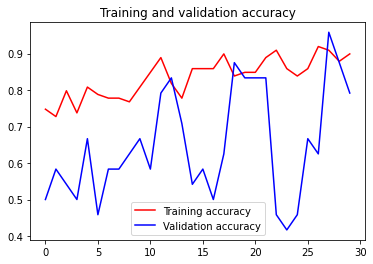

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from keras.models import load_model

model.save('Fruit_Front_Classification_InceptionV3.h5')

100%|████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 390985.92it/s]
No handles with labels found to put in legend.
  0%|                                                                                          | 0/129 [00:00<?, ?it/s]


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-9d_dfo3_\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


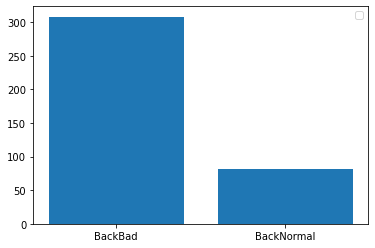

In [35]:
X_train2, X_val2, Y_train2, Y_val2, train_generator2, validation_generator2 = Integrated('C:/Users/sdf80/Desktop/fruit_dataset2/Bad_Normal/Back/Mix/', 'BackBad', 'BackNormal')

nb_train_samples = len(X_train2) 
nb_validation_samples = len(X_val2) 